# RGI12 (Caucasus and Middle East)

F. Maussion & F. Roura Adserias & S. Galos

In [1]:
import pandas as pd
import geopandas as gpd
import subprocess
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import numpy as np
from utils import mkdir, submission_summary, needs_size_filter, size_filter, plot_map, plot_date_hist, find_duplicates, find_neighbors, correct_geoms
import os

## Files and storage paths

In [2]:
# Region of interest 
reg = 12

# go down from rgi7_scripts/workflow
data_dir = '../../rgi7_data/'

# Level 2 GLIMS files
l2_dir = os.path.join(data_dir, 'l2_sel_reg_tars')

# Output directories
output_dir = mkdir(os.path.join(data_dir, 'l3_rgi7a'))
output_dir_tar = mkdir(os.path.join(data_dir, 'l3_rgi7a_tar'))

# RGI v6 file for comparison later 
rgi6_reg_file = os.path.join(data_dir, 'l0_RGIv6', '12_rgi60_CaucasusMiddleEast.zip')

# Specific to this region: boxes where data has to be selected differently
support_dir = os.path.join(data_dir, 'l0_support_data')

### Load the input data

In [3]:
# Read L2 files
shp = gpd.read_file('tar://' + l2_dir + f'/RGI{reg:02d}.tar.gz/RGI{reg:02d}/RGI{reg:02d}.shp')

### List of submissions 

In [4]:
sdf, _ = submission_summary(shp)
sdf

,N,A,analysts,submitters,release_date,geog_area,src_date_mode,src_date_min,src_date_max
subm_id,,,,,,,,,
76,51,14.8,Nosenko,Khromova,2005,Siberian Mountains,2004,2004,2004
79,16,3.4,Nosenko,Khromova,2005,Siberian Mountains,2004,2004,2004
81,53,38.0,Nosenko,Khromova,2005,Siberian Mountains,2004,2004,2004
83,13,14.1,Nosenko,Khromova,2005,Siberian Mountains,2004,2004,2004
87,12,9.2,Nosenko,Khromova,2005,Siberian Mountains,2004,2004,2004
327,4,0.3,Khromova,Khromova,2006,Siberian Mountains,2001,2001,2001
341,463,340.3,Seliverstov,Khromova,2006,Siberian Mountains,2000,2000,2000
423,34,28.5,Nosenko,Khromova,2007,Siberian Mountains,2004,2004,2004
424,19,17.2,Nosenko,Khromova,2007,Russian Glaciers (exact boundaries of RC to be...,1999,1999,1999


Notes based on inidivual submission evaluations: 
- subm 76 to 429 are all in Caucasus (we don't use them because now have subm 762 there)
- subm 588 is Iran (looks like this was what was used for RGI6)
- subm 662 is Turkey (looks like this was what was used for RGI6)
- 762 is the submission to rule them all! Updates all the outlines in Region 12. Thanks Levan

In [5]:
# # Write out selection in intermediate shape files for manual GIS review
# tmp_output_dir = mkdir(os.path.join(data_dir, 'l0_tmp_data', 'rgi12_inventories'))
# tmp_output_dir_tar = mkdir(os.path.join(data_dir, 'l0_tmp_data'))
# for subid in shp.subm_id.unique():
#     s_loc = shp.loc[shp.subm_id == subid]
#     s_loc.to_file(tmp_output_dir + f'/subm_{int(subid):03d}.shp')
# print('Taring...')
# print(subprocess.run(['tar', '-zcvf', f'{tmp_output_dir_tar}/rgi12_inventories.tar.gz', '-C', 
#                       os.path.join(data_dir, 'l0_tmp_data'), 'rgi12_inventories']))

### Apply selection criteria to create the RGI7 data subset

In [6]:
rgi7 = shp.loc[shp['subm_id'] == 762].copy()
rgi7['is_rgi6'] = False

### Filter small glaciers 

In [7]:
print(len(rgi7))
rgi7 = size_filter(rgi7)
print(len(rgi7))

2277
2277


### Some sanity checks 

In [11]:
dupes = find_duplicates(rgi7)

Potential duplicates: 1


In [12]:
nb = find_neighbors(dupes, rgi7, n=3)

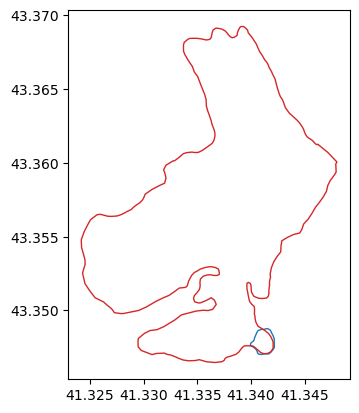

In [13]:
nb.iloc[[0, -1]].plot(edgecolor=['C0', 'C3'], color='None');

In [15]:
rgi7 = rgi7.loc[~rgi7.anlys_id.isin(dupes.anlys_id)]

In [16]:
find_duplicates(rgi7);

Seems Okay!


In [17]:
rgi7 = correct_geoms(rgi7)

Found 0 invalid geometries out of 2276. Correcting...
After correction, 0 geometries are still invalid.
Area changed by 0.0 m2 (0.0000%)


In [18]:
needs_size_filter(rgi7)

False

In [19]:
sdf, df_class = submission_summary(rgi7)
df_class

,N,N NA
subm_id,,
762,2276,2276


In [20]:
# Check the orphaned rock outcrops
orphan_f = os.path.join(data_dir, 'l1_orphan_interiors', f'RGI{reg:02d}', f'RGI{reg:02d}.shp')
if os.path.exists(orphan_f):
    orphan_f = gpd.read_file(orphan_f)
    check = np.isin(rgi7.subm_id.unique(), orphan_f.subm_id.unique())
    if np.any(check):
        print(f'Orphan rock outcrops detected in subm_id {rgi7.subm_id.unique()[check]}')
        orphan_f['area'] = orphan_f.to_crs({'proj':'cea'}).area

In [21]:
out = find_duplicates(rgi7);

Seems Okay!


### Plots 

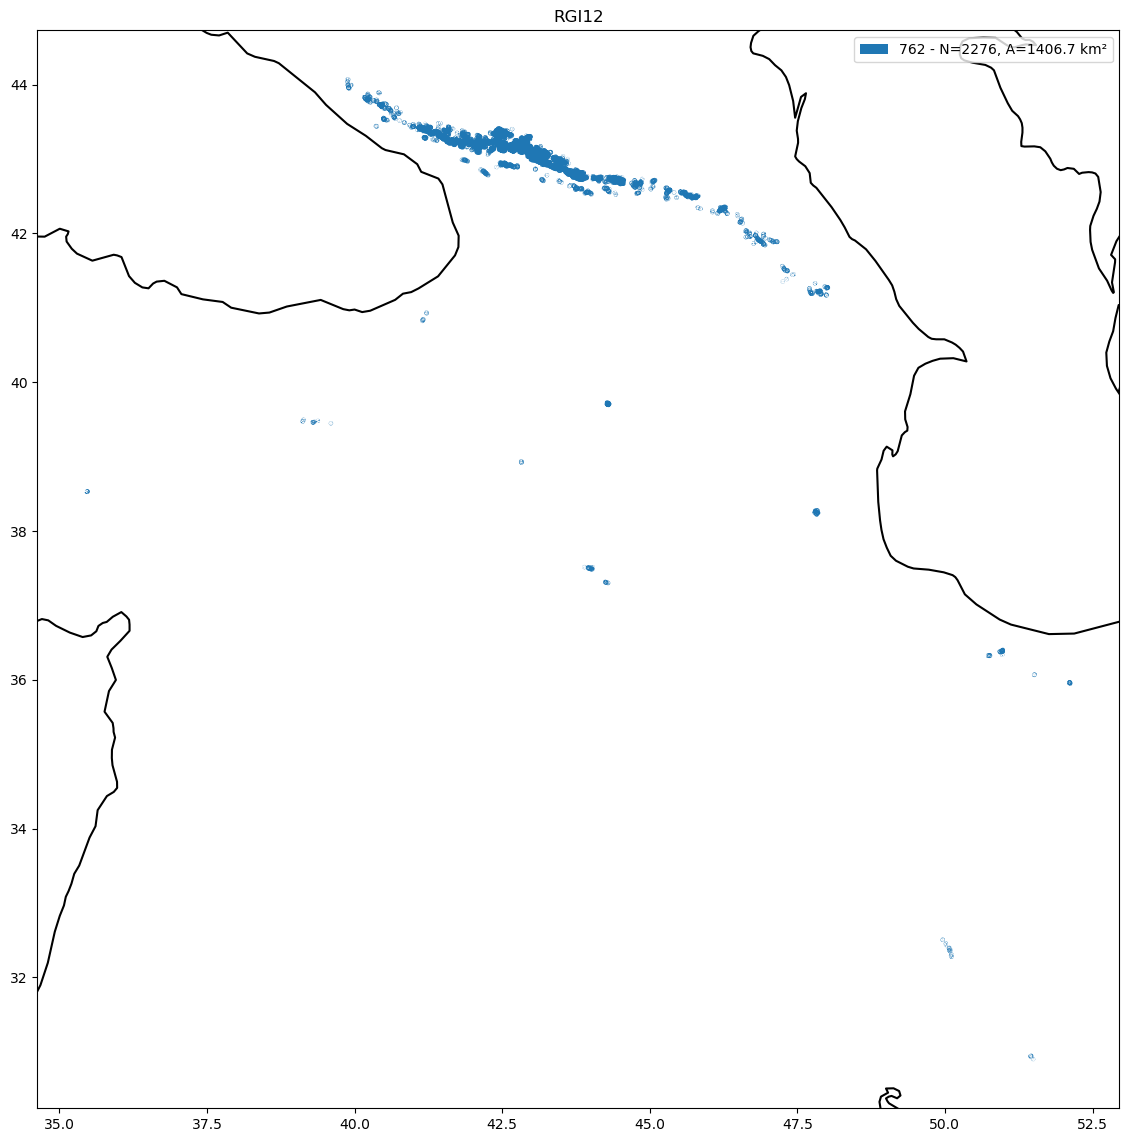

In [22]:
plot_map(rgi7, reg, linewidth=3)

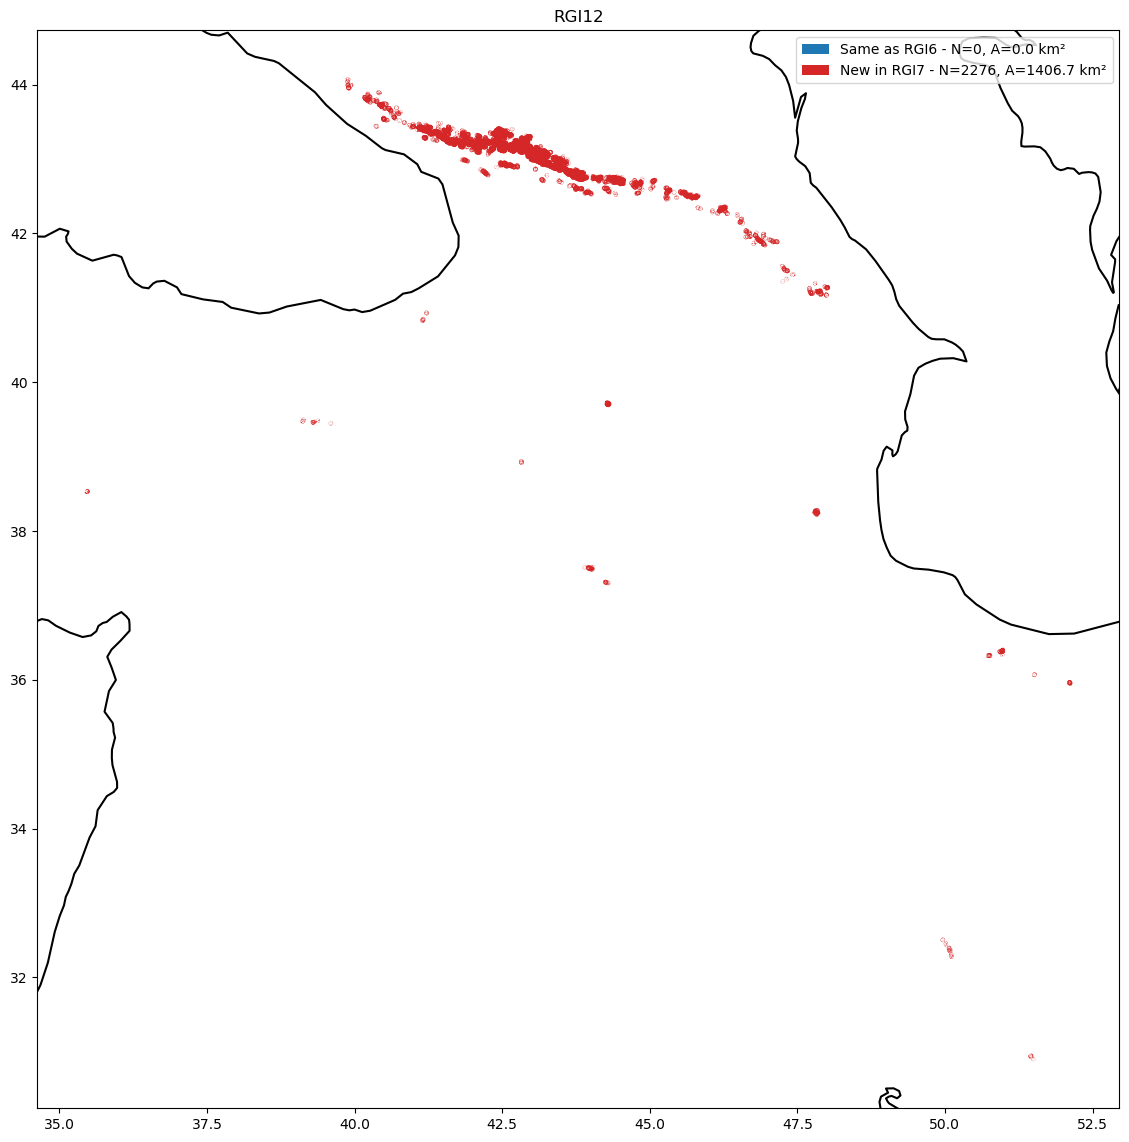

In [23]:
plot_map(rgi7, reg, linewidth=3, is_rgi6=True)

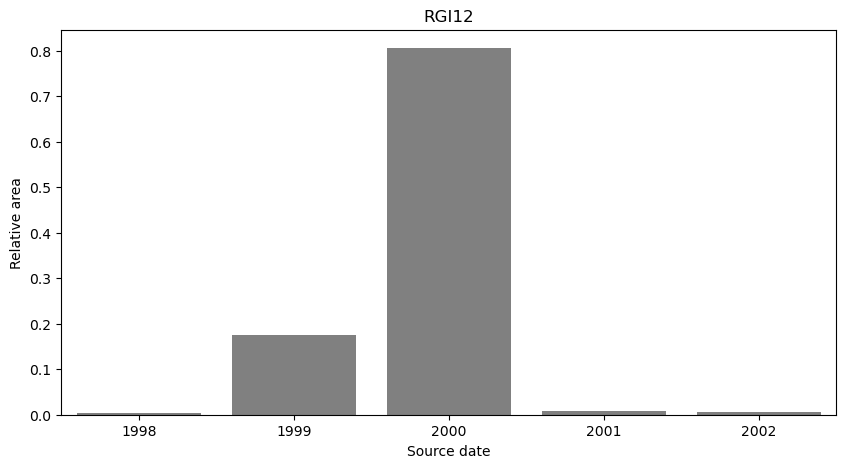

In [24]:
plot_date_hist(rgi7, reg)

### Text for github

In [25]:
fgh = sdf.T
fgh

subm_id,762
N,2276
A,1406.7
analysts,Tielidze
submitters,Tielidze
release_date,2021
geog_area,Caucausus Region
src_date_mode,2000
src_date_min,1998
src_date_max,2002


In [26]:
print(fgh.to_markdown(headers=np.append(['subm_id'], fgh.columns)))

| subm_id       | 762              |
|:--------------|:-----------------|
| N             | 2276             |
| A             | 1406.7           |
| analysts      | Tielidze         |
| submitters    | Tielidze         |
| release_date  | 2021             |
| geog_area     | Caucausus Region |
| src_date_mode | 2000             |
| src_date_min  | 1998             |
| src_date_max  | 2002             |


## Write out and tar 

In [27]:
dd = mkdir(f'{output_dir}/RGI{reg:02d}/', reset=True)

print('Writing...')
rgi7.to_file(dd + f'RGI{reg:02d}.shp')

print('Taring...')
print(subprocess.run(['tar', '-zcvf', f'{output_dir_tar}/RGI{reg:02d}.tar.gz', '-C', output_dir, f'RGI{reg:02d}']))

Writing...
Taring...
RGI12/
RGI12/RGI12.shp
RGI12/RGI12.dbf
RGI12/RGI12.shx
RGI12/RGI12.prj
RGI12/RGI12.cpg
CompletedProcess(args=['tar', '-zcvf', '../../rgi7_data/l3_rgi7a_tar/RGI12.tar.gz', '-C', '../../rgi7_data/l3_rgi7a', 'RGI12'], returncode=0)


## New RGI-file created - Check result!

### load reference data (here RGI6) to enable comparison

In [48]:
# load reference data
from utils import open_zip_shapefile
ref_odf = open_zip_shapefile(rgi6_reg_file)

## Compare new RGI7-file to RGI6

### Number of elements (differences do not necessarily depict major problems)

In [49]:
print('Number of glaciers in new RGI:', len(rgi7))
print('Number of glaciers in RGI6:', len(ref_odf))
print('Difference:', len(rgi7)-len(ref_odf))

Number of glaciers in new RGI: 2276
Number of glaciers in RGI6: 1888
Difference: 388


### How many nominal glaciers were there in RGI06-R12?

In [50]:
len(ref_odf.loc[ref_odf.Status == 2])

339

### Total area

In [51]:
# add an area field to RGI_ss and reference data
ref_odf['area'] = ref_odf.to_crs({'proj':'cea'}).area

In [52]:
# print and compare area values
Area_RGI = rgi7['area'].sum() * 1e-6
print('Area RGI7 [km²]:', Area_RGI)
Area_ref = ref_odf['area'].sum() * 1e-6
print('Area RGI6 [km²]:', Area_ref)
d = (Area_RGI - Area_ref)
print('Area difference [km²]:', d)

Area RGI7 [km²]: 1406.7183929982018
Area RGI6 [km²]: 1306.999710204219
Area difference [km²]: 99.71868279398291
